In [1]:
import pandas as pd
import deepchem as dc
from deepchem.models.optimizers import ExponentialDecay

from qsar.gan.gan_featurizer import QsarGanFeaturizer
from qsar.gan.qsar_gan import QsarGan
from qsar.gan.extract_descriptors import DescriptorsExtractor
from qsar.utils.visualizer import Visualizer

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
Skipped loading some PyTorch models, missing a dependency. No module named 'torch_geometric'
No module named 'torch_geometric'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'pytorch_lightning'
Skipped loading some Jax models, missing a dependency. jax requires jaxlib to be installed. See https://github.com/google/jax#installation for installation instructions.


# Data importation

In [2]:
# our dataset (183 smiles)
df = pd.read_csv('../data/unfiltered_data_smiles.csv')
data_local = df[['SMILES']]
data_local.columns = [col.lower() for col in data_local.columns]

# Tox21 Dataset: Contains bioactivity data for various chemicals in toxicity assays, used for toxicology research and safety assessments.
# https://paperswithcode.com/dataset/tox21-1
_, datasets, _ = dc.molnet.load_tox21()
data_tox21 = pd.DataFrame(data={'smiles': datasets[0].ids})

# Lipo Dataset: Provides lipophilicity data (logP values) of chemical compounds, aiding in studies of compound absorption and metabolism in pharmacology.
# https://www.ebi.ac.uk/chembl/document_report_card/CHEMBL3301361/
_, datasets, _ = dc.molnet.load_lipo()
data_lipo = pd.DataFrame(data={'smiles': datasets[0].ids})

# thought of combining all datasets might maximise the GAN perf and boost the prediction
data = pd.concat([data_local, data_tox21], ignore_index=True)
display(data)

,smiles
0,O=C(Nc1ccc(O)cc1)C
1,ClC1(Cl)C2(Cl)C3(Cl)C4(Cl)C(Cl)(Cl)C5(Cl)C3(Cl...
2,S(=O)(=O)(N)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F...
3,S(CCNC(=NC#N)NC)Cc1c(C)[nH]c[n+H]1
4,OCC
...,...
6442,CC1CCCCN1CCCOC(=O)c1ccc(OC2CCCCC2)cc1
6443,Cc1cc(CCCOc2c(C)cc(-c3noc(C(F)(F)F)n3)cc2C)on1
6444,O=C1OC(OC(=O)c2cccnc2Nc2cccc(C(F)(F)F)c2)c2ccc...
6445,CC(=O)C1(C)CC2=C(CCCC2(C)C)CC1C


# Determine the max atom count threshold

[02:32:40] SMILES Parse Error: syntax error while parsing: S(CCNC(=NC#N)NC)Cc1c(C)[nH]c[n+H]1
[02:32:40] SMILES Parse Error: Failed parsing SMILES 'S(CCNC(=NC#N)NC)Cc1c(C)[nH]c[n+H]1' for input: 'S(CCNC(=NC#N)NC)Cc1c(C)[nH]c[n+H]1'
[02:32:40] SMILES Parse Error: syntax error while parsing: [N+H3]C(Cc1ccccc1)C
[02:32:40] SMILES Parse Error: Failed parsing SMILES '[N+H3]C(Cc1ccccc1)C' for input: '[N+H3]C(Cc1ccccc1)C'
[02:32:40] SMILES Parse Error: syntax error while parsing: O=[SH0]1c2c(/C(=C/CC[N+H](C)C)/c3c(cccc3)C1)cccc2
[02:32:40] SMILES Parse Error: Failed parsing SMILES 'O=[SH0]1c2c(/C(=C/CC[N+H](C)C)/c3c(cccc3)C1)cccc2' for input: 'O=[SH0]1c2c(/C(=C/CC[N+H](C)C)/c3c(cccc3)C1)cccc2'
[02:32:40] SMILES Parse Error: syntax error while parsing: FC(F)(F)c1ccc(OC(CC[N+H3])c2ccccc2)cc1
[02:32:40] SMILES Parse Error: Failed parsing SMILES 'FC(F)(F)c1ccc(OC(CC[N+H3])c2ccccc2)cc1' for input: 'FC(F)(F)c1ccc(OC(CC[N+H3])c2ccccc2)cc1'
[02:32:40] SMILES Parse Error: syntax error while parsing: C

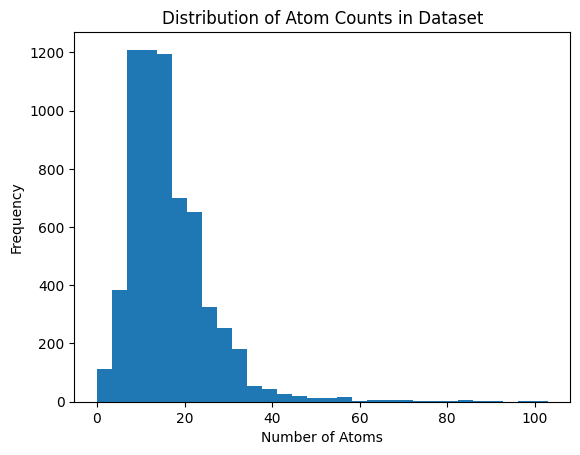

Max atom count: 32


In [3]:
featurizer = QsarGanFeaturizer()
max_atom_count, atom_counts = featurizer.determine_atom_count(smiles=data, quantile=0.95)
visualizer = Visualizer()
visualizer.display_atom_count_distribution(atom_counts)
print(f'Max atom count: {max_atom_count}')

# Featurize the data

In [9]:
features = featurizer.get_features(data.copy())

[02:32:41] SMILES Parse Error: syntax error while parsing: S(CCNC(=NC#N)NC)Cc1c(C)[nH]c[n+H]1
[02:32:41] SMILES Parse Error: Failed parsing SMILES 'S(CCNC(=NC#N)NC)Cc1c(C)[nH]c[n+H]1' for input: 'S(CCNC(=NC#N)NC)Cc1c(C)[nH]c[n+H]1'
[02:32:41] SMILES Parse Error: syntax error while parsing: [N+H3]C(Cc1ccccc1)C
[02:32:41] SMILES Parse Error: Failed parsing SMILES '[N+H3]C(Cc1ccccc1)C' for input: '[N+H3]C(Cc1ccccc1)C'
[02:32:41] SMILES Parse Error: syntax error while parsing: O=[SH0]1c2c(/C(=C/CC[N+H](C)C)/c3c(cccc3)C1)cccc2
[02:32:41] SMILES Parse Error: Failed parsing SMILES 'O=[SH0]1c2c(/C(=C/CC[N+H](C)C)/c3c(cccc3)C1)cccc2' for input: 'O=[SH0]1c2c(/C(=C/CC[N+H](C)C)/c3c(cccc3)C1)cccc2'
[02:32:41] SMILES Parse Error: syntax error while parsing: FC(F)(F)c1ccc(OC(CC[N+H3])c2ccccc2)cc1
[02:32:41] SMILES Parse Error: Failed parsing SMILES 'FC(F)(F)c1ccc(OC(CC[N+H3])c2ccccc2)cc1' for input: 'FC(F)(F)c1ccc(OC(CC[N+H3])c2ccccc2)cc1'
[02:32:41] SMILES Parse Error: syntax error while parsing: C

# Train the Gan and generate data

In [13]:
gan = QsarGan(featurizer=featurizer, learning_rate=ExponentialDecay(0.001, 0.9, 5000))
generated_smiles = gan.fit_predict(features=features, epochs=128)
display(generated_smiles)

Ending global_step 767: generator average loss -15.8683, discriminator average loss -9.29114
TIMING: model fitting took 28.469 s
Generating 10000 samples


[02:34:13] Explicit valence for atom # 0 C, 8, is greater than permitted
[02:34:13] non-ring atom 0 marked aromatic
[02:34:13] Explicit valence for atom # 0 C, 8, is greater than permitted
[02:34:13] Explicit valence for atom # 0 C, 8, is greater than permitted
[02:34:13] non-ring atom 0 marked aromatic
[02:34:13] Explicit valence for atom # 0 C, 8, is greater than permitted
[02:34:13] Explicit valence for atom # 0 C, 8, is greater than permitted
[02:34:13] non-ring atom 0 marked aromatic
[02:34:13] non-ring atom 0 marked aromatic
[02:34:13] Explicit valence for atom # 0 O, 10, is greater than permitted
[02:34:13] Explicit valence for atom # 0 C, 8, is greater than permitted
[02:34:13] Explicit valence for atom # 0 C, 8, is greater than permitted
[02:34:13] Explicit valence for atom # 0 C, 8, is greater than permitted
[02:34:13] Explicit valence for atom # 8 C, 6, is greater than permitted
[02:34:13] non-ring atom 0 marked aromatic
[02:34:13] non-ring atom 0 marked aromatic
[02:34:13] 

# Extract Descriptors

In [14]:
data_with_descriptors = DescriptorsExtractor.extract_descriptors(generated_smiles)
display(data_with_descriptors)

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,SPS
<rdkit.Chem.rdchem.Mol object at 0x000001E458CEB3E0>,2.125000,2.125000,1.250000,1.250000,0.385471,6.000000,44.097,36.033,44.062600,20,...,0,0,0,0,0,0,0,0,0,6.000000
<rdkit.Chem.rdchem.Mol object at 0x000001E458CEB450>,4.847222,4.847222,0.750000,0.750000,0.406237,6.000000,45.085,38.029,45.057849,20,...,0,0,0,0,0,0,0,0,0,6.000000
<rdkit.Chem.rdchem.Mol object at 0x000001E458CEB4C0>,7.347222,7.347222,0.250000,-0.250000,0.340426,6.000000,47.057,42.017,47.037114,20,...,0,0,0,0,0,0,0,0,0,6.000000
<rdkit.Chem.rdchem.Mol object at 0x000001E458CEB530>,3.144610,3.144610,1.184240,1.184240,0.541921,10.000000,129.247,110.095,129.151750,56,...,0,0,0,0,0,0,0,4,0,10.000000
<rdkit.Chem.rdchem.Mol object at 0x000001E458CEB5A0>,2.180556,2.180556,1.319444,1.319444,0.431024,7.500000,58.124,48.044,58.078250,26,...,0,0,0,0,0,0,0,0,0,7.500000
<rdkit.Chem.rdchem.Mol object at 0x000001E458CEB610>,5.310743,5.310743,0.864796,0.864796,0.544132,9.750000,115.220,98.084,115.136100,50,...,0,0,0,0,0,0,0,3,0,9.750000
<rdkit.Chem.rdchem.Mol object at 0x000001E458CEB680>,3.102500,3.102500,1.174444,1.174444,0.527646,9.428571,101.193,86.073,101.120449,44,...,0,0,0,0,0,0,0,2,0,9.428571
<rdkit.Chem.rdchem.Mol object at 0x000001E458CEB6F0>,2.357130,2.357130,0.935463,0.935463,0.505760,23.000000,126.243,108.099,126.140851,54,...,0,0,0,0,0,0,0,0,0,23.000000
<rdkit.Chem.rdchem.Mol object at 0x000001E458CEB760>,2.245694,2.245694,1.361111,1.361111,0.476310,9.428571,100.205,84.077,100.125201,44,...,0,0,0,0,0,0,0,2,0,9.428571
<rdkit.Chem.rdchem.Mol object at 0x000001E458CEB7D0>,5.291667,5.291667,0.384259,0.384259,0.486540,15.000000,73.139,62.051,73.089149,32,...,0,0,0,0,0,0,0,0,0,15.000000


# Display the generated molecules

In [15]:
visualizer.draw_generated_molecules(generated_smiles)